Introduction to Data Science <br> Winter 2018

# Homework 9
Due Sunday, 3/11/2018 , 3:00am

Please complete this notebook by filling in the cells provided. Once you are finished, "Save and Checkpoint" the notebook, download the ipynb and html versions to your computer, and submit the html version. 

**Total points:** 145

In [2]:
!pip install datascience

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier


    100% |████████████████████████████████| 40kB 2.2MB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 2.9MB/s eta 0:00:01
    100% |████████████████████████████████| 286kB 2.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for datascience ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/f7/28/00/e2de1c86cfb882f8ffbc46bc17bccaa8f0295dcc394595396b
  Running setup.py bdist_wheel for folium ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/97/f3/25/51a7acd11b6663869c0723fe1c3f63c74725f3243d01d61ea7
  Running setup.py bdist_wheel for coverage ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/09/d5/14/fad8864342631171117f01b9b2473a07c053e5c1054d40e48c
  Running setup.py bdist_wheel for coveralls ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/c1/39/ce/1ad042a101a8475a7b9e8344f53a789c9eeb2697ed3e8dd35b
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/b2/16/5f/c33a2bb5

## 1. How Faithful is Old Faithful? 

(Note: clever title comes from [here](http://web.pdx.edu/~jfreder/M212/oldfaithful.pdf).)

Old Faithful is a geyser in Yellowstone National Park in the central United States.  It's famous for erupting on a fairly regular schedule.  You can see a video below.

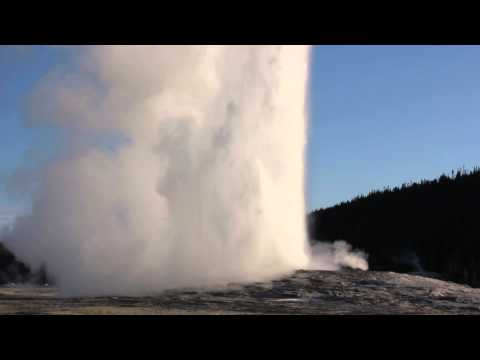

In [3]:

from IPython.display import YouTubeVideo
YouTubeVideo("wE8NDuzt8eg")

In [3]:
faithful = Table.read_table("faithful.csv")

faithful = faithful.sort('duration')
faithful

duration,wait
1.6,52
1.667,64
1.7,59
1.733,54
1.75,47
1.75,62
1.75,47
1.75,58
1.75,48
1.75,54


use linear regression to make predictions


Make a scatterplot of the data. 

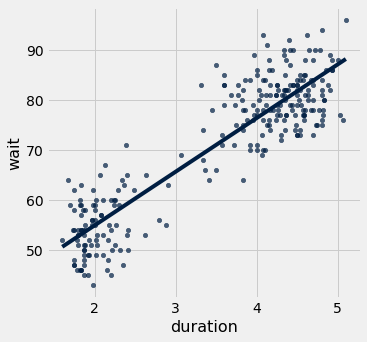

In [4]:
faithful.scatter("duration", fit_line = True)

**Question 2** (5 points)

Look at the scatterplot. Are eruption duration and waiting time roughly linearly related?  Is the relationship positive, as we claimed earlier?  You may want to consult [the textbook chapter 15](https://www.inferentialthinking.com/chapters/15/prediction.html) for the definition of "linearly related."

It seems like there are two clusters. Also each clusters are nearly linear.

**Question 3** (10 points)

Use the linear regession module from scikit-learn to fit the least squares line to the data. Print the slope and the intercept of the line.

**Hint:** Take a look at "Statistical learning Part 1"

In [5]:
lin_reg = LinearRegression()
x = faithful.column('duration').reshape(-1,1)
lin_reg.fit(x,faithful.column('wait'))
a = lin_reg.intercept_
b = lin_reg.coef_[0]
print("slope : ", b)
print("intercept : ", a)

slope :  10.7296413951
intercept :  33.4743970228


**Question 4** (10 points)

Calculate median absolute prediction error, mean squared prediction error, and coefficient of determination R^2.

In [6]:

# increase as prediction get worse
def mae(y,y_hat):
    return np.median(np.abs(y-y_hat))

def mse(y,y_hat):
    return np.mean((y-y_hat)**2)

# 1 is good 0 is bad, no relationship.
def rsq(y,y_hat):
    ss_residual = ((y - y_hat)**2).sum()
    ss_total = ((y - y.mean())**2).sum()
    return (1 - ss_residual/ss_total)

y = faithful.column("wait")
y_reg = lin_reg.predict(x)

print("median absolute prediction error : ", mae(y, y_reg))
print("mean squared prediction error : ", mse(y, y_reg))
print("R^2 : ", rsq(y, y_reg))
    

median absolute prediction error :  4.10406849844
mean squared prediction error :  34.7183347287
R^2 :  0.811460760973


**Question 5** (10 points)

Divide the data into a subset "short" containing eruptions of duration < 3min and  a subset "long " containing the rest.

A simple rule would be use a piecewise constant predictor: predict the waiting time after a short eruption by np.mean(short.column("wait")) and the waiting time after a long eruption by np.mean(long.column("wait")).

Calculate median absolute prediction error, mean squared prediction error, and coefficient of determination R^2 for the piecewise constant predictor.

In [7]:
short = faithful.where('duration', are.below(3))
long = faithful.where('duration', are.above_or_equal_to(3))
short_mean = short.column('wait').mean()
long_mean = long.column('wait').mean()
y_pc = np.array([short_mean]*short.num_rows + [long_mean]*long.num_rows)
faithful = faithful.with_column('piecewise_constant', y_pc)

print ("median absolute prediction error : ", mae(faithful.column("wait"), faithful.column('piecewise_constant')))
print ("mean squared prediction error : ", mse(faithful.column("wait"), faithful.column('piecewise_constant')))
print ("R^2 : ", rsq(faithful.column("wait"), faithful.column('piecewise_constant')))


median absolute prediction error :  3.98857142857
mean squared prediction error :  35.0228844321
R^2 :  0.80980689221


**Question 6** (10 points)

Is the linear predictor doing better, about the same, or worse that the piecewise constant predictor? Justify your answer.

Bothe linear and piecewise predictors predicts the data about the same, but linear predictor is slightly better prediction than piecewise constant predictor.

## 2. Implementing a k-nearest-neighbor classifier

In [8]:
# Here is code to make a small table mini_train for debugging

mini_train = Table().with_columns("0", [0, 1, 3, 7], "1", [0, 0, 0, 0], "response", ["0", "1", "0", "1"])
mini_train.show()

0,1,response
0,0,0
1,0,1
3,0,0
7,0,1


In [1]:

digit_train = Table.read_table("optdigits-mini-train.csv")
digit_train = digit_train.relabel("64", "response")  # relabel modifies

digit_test = Table.read_table("optdigits-mini-test.csv")
digit_test = digit_test.relabel("64", "response")


NameError: name 'Table' is not defined

In [10]:
def dist(x,y):
    square = (x-y)**2
    return (sum(square)**0.5)

def find_distance_and_lables(test_digit, train_table):
    distance_array = np.zeros(train_table.num_rows)
    
    for i in np.arange(0, train_table.num_rows):
        x = np.array(train_table.drop("response").row(i))
        y = np.array(test_digit)
        distance = dist(x,y)
        distance_array[i] = distance
        
    return_table = Table().with_columns("distance", distance_array,
                                       'label',train_table.column("response"))
    return(return_table.sort("distance"))

def find_labels_of_nearest_neighbors(training_sample, response_name, test_sample, kmax = 10):
    nearest_neighbor_label = Table()
    train = training_sample
    test = test_sample.drop(response_name)
    for i in np.arange(0, test.num_rows):
        t = find_distance_and_lables(test.row(i),train).column("label")[:kmax]
        nearest_neighbor_label.append_column(str(i), t)
    return nearest_neighbor_label
    
find_labels_of_nearest_neighbors(digit_train,"response",digit_test, 10)
    

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,8,1,1,5,1,1,2,2,2,2,2,2,2,9,2,2,2,2,2,2,2,2,2,1,2,2,3,3,3,3,3,3,3,3,3,3,3,9,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,9,5,8,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,8,8,8,8,1,8,8,8,8,8,8,9,8,8,3,8,8,8,5,8,9,3,9,9,9,9,9,9,9,1,8,9,9,9,9,9,9,9,9,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,1,1,1,1,1,1,1,1,1,1,3,5,1,2,2,2,2,2,2,2,3,2,2,9,2,2,3,2,2,2,2,2,2,3,3,3,5,3,3,9,3,3,3,3,3,3,3,3,3,3,3,3,3,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,9,5,3,5,5,5,6,5,5,5,5,5,3,9,5,8,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,2,7,7,7,7,7,7,7,7,7,8,8,8,8,1,6,8,8,8,8,8,8,8,8,8,8,8,3,5,8,9,3,9,9,9,9,9,9,9,9,9,9,5,9,9,9,9,9,9,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,1,1,1,2,1,1,1,8,9,1,1,1,1,1,1,3,1,2,2,2,2,2,2,2,9,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,5,3,3,3,2,3,3,3,9,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,9,3,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,4,3,7,2,7,7,7,7,7,7,7,7,7,8,8,8,8,8,9,3,8,3,8,8,8,8,8,8,8,8,3,3,3,9,9,9,9,3,3,3,9,9,9,9,9,9,9,9,1,5,9,9,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,5,8,1,1,2,1,1,1,1,1,1,1,1,1,1,1,3,1,2,2,8,2,2,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,8,5,3,3,3,3,3,3,3,3,3,3,3,3,9,4,4,4,4,4,4,4,4,4,4,4,9,4,4,1,4,4,4,4,4,4,5,9,5,9,5,5,5,5,5,5,5,9,5,5,6,3,9,8,8,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,1,7,7,7,7,7,7,2,7,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,1,8,8,8,8,9,3,9,9,9,5,9,9,9,9,5,9,9,9,9,9,9,9,9,5
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,2,8,8,1,3,1,1,1,1,9,9,1,1,9,8,1,9,1,2,2,2,2,2,2,2,9,3,2,2,2,2,2,8,2,2,2,2,2,7,3,3,8,3,8,3,3,3,1,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,1,4,4,4,4,4,9,1,7,4,4,4,4,4,4,5,5,9,5,8,5,5,5,5,5,4,5,5,5,5,5,5,9,8,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,2,7,7,7,7,7,7,7,7,7,7,7,9,7,8,8,1,9,8,8,8,8,8,9,8,3,8,8,5,8,0,8,3,9,9,4,3,9,9,4,9,4,9,9,9,8,9,3,9,9,9,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,8,1,1,8,1,1,1,8,1,8,1,1,8,1,1,1,2,9,1,2,2,2,2,2,2,2,9,3,2,8,2,2,2,2,2,2,1,2,2,3,3,3,5,3,3,3,3,3,3,3,3,5,3,3,3,3,3,3,3,1,4,4,6,4,4,4,4,4,4,4,4,4,7,4,4,4,4,4,6,5,5,5,5,3,5,8,3,5,5,5,9,5,5,5,5,3,3,8,8,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,9,7,7,7,7,7,7,7,7,7,7,8,8,3,2,8,8,9,8,8,8,8,8,3,8,1,8,8,3,3,2,3,8,9,9,1,9,9,1,3,1,3,8,1,9,5,3,9,5,3,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,8,1,8,3,4,1,8,1,9,1,1,8,4,1,5,1,5,2,2,8,2,2,2,2,2,9,2,2,2,2,3,2,2,2,2,2,2,3,9,3,3,3,3,3,3,7,3,3,3,3,3,9,3,3,3,3,9,1,4,4,6,4,1,4,4,4,4,4,4,4,4,4,4,4,6,4,4,4,8,5,9,9,5,5,3,5,5,6,9,5,5,5,5,5,5,0,1,6,6,6,6,1,6,6,6,6,6,6,6,5,4,6,6,6,6,6,6,2,7,7,7,7,7,1,7,8,7,7,7,7,7,7,7,7,7,7,3,3,8,3,8,8,9,3,8,8,8,2,9,3,3,5,1,8,3,0,8,9,5,9,4,9,9,9,4,0,9,0,5,9,9,9,9,9,5,9,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,3,1,1,8,3,1,1,8,8,9,1,1,8,1,1,1,3,1,2,2,8,2,2,2,2,2,3,2,3,2,2,9,8,2,2,2,2,2,7,9,3,8,3,3,8,9,3,3,3,9,3,3,9,3,3,3,3,9,4,4,4,4,4,4,4,4,6,8,4,9,4,4,4,4,4,1,4,6,5,5,9,5,3,8,8,5,5,5,5,9,5,5,5,8,5,9,5,1,6,6,6,6,1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,8,7,7,7,7,7,7,3,7,7,7,7,7,8,8,3,8,8,8,8,1,8,6,8,9,1,8,3,1,5,8,5,8,0,3,5,9,9,3,0,9,3,9,4,3,9,3,8,3,3,9,5,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,1,8,1,1,1,1,8,9,8,9,4,8,1,1,1,2,1,4,2,2,2,2,2,2,8,3,3,2,8,2,2,2,2,

In [11]:
# Run this cell

mini_nearest_neighbor_labels = find_labels_of_nearest_neighbors(mini_train, "response", mini_train.drop("response"), 3)
mini_nearest_neighbor_labels

0,1,2,3
0,1,0,1
1,0,1,0
0,0,0,1


In [13]:
# Run this cell

digit_nearest_neighbor_labels = find_labels_of_nearest_neighbors(digit_train, "response", \
                                                                 digit_train.drop("response"), 10)
print(digit_nearest_neighbor_labels.column("0"))
print(digit_nearest_neighbor_labels.column("21"))
print(digit_nearest_neighbor_labels.column("181"))


[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 9 4 1 8 1]
[9 9 9 9 9 3 9 9 9 3]




***majority_vote(nearest_neighbor_labels, k)*** -  return an array of length ntest containing the predicted class labels for the test observations.



In [14]:
def majority_vote(nearest_neighbor_labels, k):
    tab = nearest_neighbor_labels.take(range(0,k))
    return_array = np.zeros(nearest_neighbor_labels.num_columns)
    for i in np.arange(0, nearest_neighbor_labels.num_columns):
        tab2 = tab.select(str(i)).group(str(i)).sort("count", descending = True)
        x = tab2.column(str(i))[0]
        return_array[i] = x
    return return_array

In [15]:
# Run this cell

mini_majority_vote = majority_vote(mini_nearest_neighbor_labels, 3)
mini_majority_vote

array([ 0.,  0.,  0.,  1.])

In [16]:
# Run this cell

digit_majority_vote = majority_vote(digit_nearest_neighbor_labels, 10)
print(str(digit_majority_vote[0]) + "  " + str(digit_majority_vote[21]) \
      + "  " + str(digit_majority_vote[181]))

0.0  1.0  9.0


classify digit_test with k = 10. Call the result "my_prediction"

In [17]:
nearest_neighbor_labels = find_labels_of_nearest_neighbors(digit_train,"response", digit_test,10)
my_prediction = majority_vote(nearest_neighbor_labels, 10)

my_prediction 

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  8.,  9.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,
        1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  9.,  3.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  9.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  9.,  5.,
        9.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        9.,  5.,  8.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  9.,  8.,  8.,  8.,  8.,  8.,  3.,  5.,  8.,  9



Classify digit_test with k = 10.

Call the result scikit_learn_prediction

In [18]:
def knn_classifier_fit(knn_classifier, training_sample, response_name):
    ntrain = training_sample.num_rows
    response = training_sample.column(response_name)
    predictors = training_sample.drop(response_name)
    npred = predictors.num_columns
    predictor_array = np.zeros((ntrain, npred))
    for i in np.arange(npred):
        column_i = predictors.column(i)
        for j in np.arange(ntrain):
            predictor_array[j, i] = column_i[j]
    knn_classifier.fit(predictor_array, response)
    return(knn_classifier)

def knn_classifier_predict(knn_classifier, test_sample):
    ntest = test_sample.num_rows
    npred = test_sample.num_columns
    predictor_array = np.zeros((ntest, npred))
    for i in np.arange(npred):
        column_i = test_sample.column(i)
        for j in np.arange(ntest):
            predictor_array[j, i] = column_i[j]
    predicted_response = knn_classifier.predict(predictor_array)
    return(predicted_response)

In [28]:
# classify digit_test with k = 10.
k = 10
knn_classifier = KNeighborsClassifier(k)

fit_model = knn_classifier_fit(knn_classifier, digit_train, "response")
scikit_learn_prediction = knn_classifier_predict(knn_classifier, digit_test.drop("response"))


scikit_learn_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 2, 2, 2, 2,
       2, 9, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 9, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 3, 5, 8, 9, 3, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])


Count the number of test observations for which my_prediction is different from scikit_learn_prediction. Call the result num_diff

In [32]:
def count (my_prediction, scikit_learn_prediction):
    num = 0
    for i in np.arange(0, len(my_prediction)):
        if my_prediction[i] != scikit_learn_prediction[i]:
            num = num + 1
    return num

count(my_prediction, scikit_learn_prediction)

5

The difference exists because there is no unique way of majority vote. My code and scikit-learn code probably used different method for choosing majority vote.